In [1]:
"""Load combined diffusion-relaxometry data and mask"""

# Access nifti, bval & bvec files
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii') # nifti file with whole-brain MRI data
mask = join(dname, 'vol0083_brain_mask.nii.gz') # brain mask
fbval = join(dname, 'parameters_new_bval.txt') # list of b-values
fbvec = join(dname, 'parameters_new_bvec2.txt') # list of b-vectors

# Load dMRI datasets using Dipy
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [2]:
"""Set up acquisition scheme using b-values, b-vectors"""

# Import relevant modules
from dmipy.core import modeling_framework
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))

# delta and Delta times in seconds
delta = 0.0242
Delta = 0.0391

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms] |TI[ms]
0           |84        |0               |0                        |24.2       |39.1      |N/A  	|N/A  
1           |84        |500             |19                       |24.2       |39.1      |N/A  	|N/A  
2           |252       |1000            |27                       |24.2       |39.1      |N/A  	|N/A  
3           |420       |2000            |39                       |24.2       |39.1      |N/A  	|N/A  
4           |504       |3000            |48                       |24.2       |39.1      |N/A  	|N/A  


In [3]:
"""Create ball & stick model using Dmipy

This model will be fitted to all voxels of the MRI data using Dmipy's least squares approach.
"""

# Import relevant modules
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Initiate ball & stick model
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS = MultiCompartmentModel(models=[stick, ball])

# Display parameters for model
print(BAS.parameter_cardinality)

OrderedDict([('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1), ('G1Ball_1_lambda_iso', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [4]:
import time
start_time = time.time()

In [ ]:
"""Stick fibre direction"""

import numpy as np

mu = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1Stick_1_mu'])
            mu[x,y,:] = fitted_BAS.fitted_parameters['C1Stick_1_mu']
            print((x, y))
            
print(mu)

In [6]:
# Calculate time taken for prediction
print("Dmipy fitting time: %s seconds" % (time.time() - start_time))

Dmipy fitting time: 1269.5826151371002 seconds


In [ ]:
# # Save stick fibre direction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('BAS_stick_mu.nii.gz', mu, affine)

In [7]:
import time
start_time = time.time()

In [ ]:
"""Stick axial diffusivity"""

import numpy as np

lpar = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1Stick_1_lambda_par'])
            lpar[x,y,:] = fitted_BAS.fitted_parameters['C1Stick_1_lambda_par']
            print((x, y))
            
print(lpar)

In [9]:
# Calculate time taken for prediction
print("Dmipy fitting time: %s seconds" % (time.time() - start_time))

Dmipy fitting time: 1281.9551548957825 seconds


In [10]:
# # Save stick axial diffusivity as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('BAS_stick_lambda_par.nii.gz', lpar, affine)

In [12]:
import time
start_time = time.time()

In [ ]:
"""Ball diffusivity"""

import numpy as np

l_iso = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['G1Ball_1_lambda_iso'])
            l_iso[x,y,:] = fitted_BAS.fitted_parameters['G1Ball_1_lambda_iso']
            print((x, y))
            
print(l_iso)

In [14]:
# Calculate time taken for prediction
print("Dmipy fitting time: %s seconds" % (time.time() - start_time))

Dmipy fitting time: 1281.6142091751099 seconds


In [15]:
# # Save ball diffusivity as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('BAS_ball_lambda_iso.nii.gz', l_iso, affine)

In [17]:
import time
start_time = time.time()

In [ ]:
"""Ball volume fraction"""

import numpy as np

part_vol_zero = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['partial_volume_0'])
            part_vol_zero[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_0']
            print((x, y))
            
print(part_vol_zero)

In [19]:
# Calculate time taken for prediction
print("Dmipy fitting time: %s seconds" % (time.time() - start_time))

Dmipy fitting time: 1280.5017430782318 seconds


In [20]:
# # Save ball volume fraction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('BAS_partial_volume_0.nii.gz', part_vol_zero, affine)

In [22]:
import time
start_time = time.time()

In [ ]:
"""Stick volume fraction"""

import numpy as np

part_vol_one = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['partial_volume_1'])
            part_vol_one[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_1']
            print((x, y))
            
print(part_vol_one)

In [24]:
# Calculate time taken for prediction
print("Dmipy fitting time: %s seconds" % (time.time() - start_time))

Dmipy fitting time: 1272.4852831363678 seconds


In [ ]:
# # Save stick volume fraction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('BAS_partial_volume_1.nii.gz', part_vol_one, affine)

In [26]:
# Save predicted arrays as numpy array files
# np.save("normal_ball_diff", l_iso)
# np.save("normal_stick_direction", mu)
# np.save("normal_stick_diff", lpar)
# np.save("normal_vol_zero", part_vol_zero)
# np.save("normal_vol_one", part_vol_one)

In [2]:
# Load predicted arrays
import numpy as np
ball_diff = np.load("normal_ball_diff.npy")
stick_direction = np.load("normal_stick_direction.npy")
stick_diff = np.load("normal_stick_diff.npy")
ball_fraction = np.load("normal_vol_zero.npy")
stick_fraction = np.load("normal_vol_one.npy")

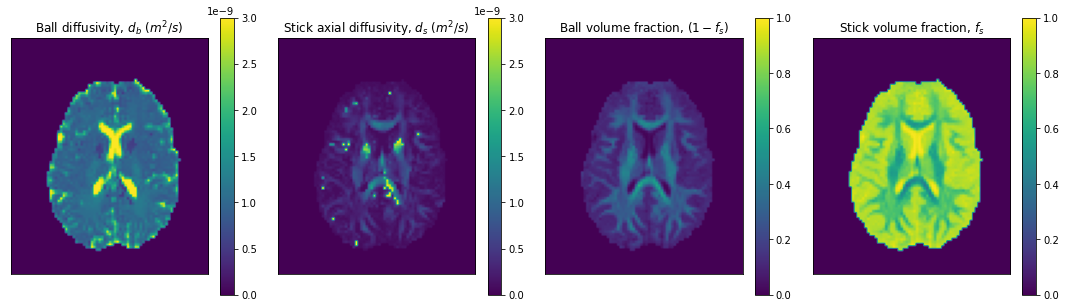

In [4]:
"""Create microstructure maps for each parameter"""

import math
import matplotlib.pyplot as plt
fig, ((ax1, ax3, ax4, ax5)) = plt.subplots(nrows=1, ncols=4, figsize=(15,8))

im1 = ax1.imshow(np.rot90(ball_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1, shrink=0.5)

im3 = ax3.imshow(np.rot90(stick_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax3.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3, shrink=0.5)

im4 = ax4.imshow(np.rot90(ball_fraction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax4.set_title("Ball volume fraction, $(1 - f_s)$") # partial_volume_0
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(im4, ax=ax4, shrink=0.5)

im5 = ax5.imshow(np.rot90(stick_fraction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax5.set_title("Stick volume fraction, $f_s$") # partial_volume_1
ax5.set_xticks([])
ax5.set_yticks([])
fig.colorbar(im5, ax=ax5, shrink=0.5)

fig.tight_layout()

plt.savefig("figure1.png", dpi=600)

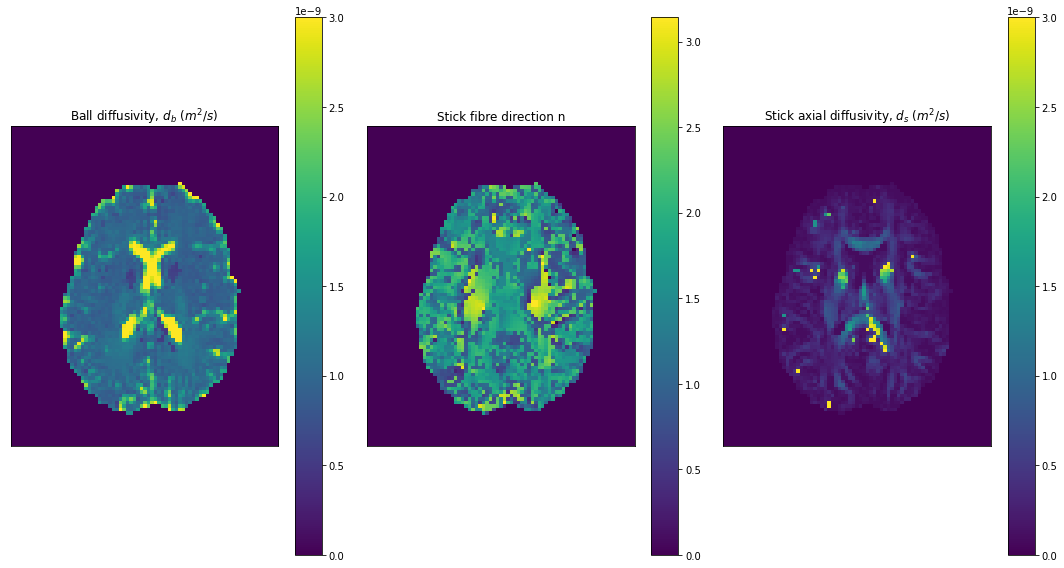

In [29]:
import math
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,8))

im1 = ax1.imshow(np.rot90(ball_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(np.rot90(stick_direction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=math.pi)
ax2.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(stick_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax3.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

fig.tight_layout()

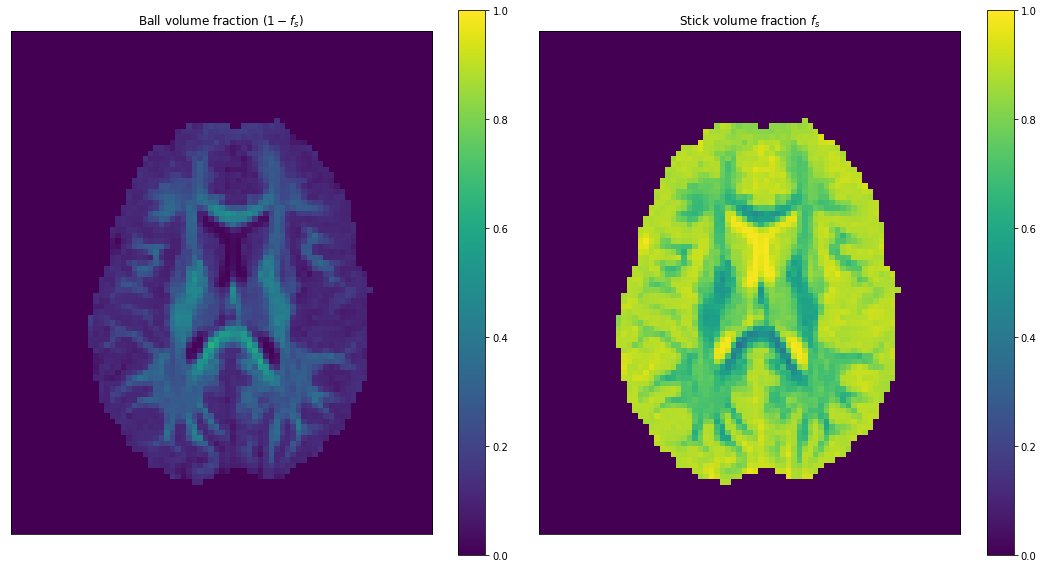

In [31]:
import matplotlib.pyplot as plt
fig, ((ax4, ax5)) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

im4 = ax4.imshow(np.rot90(ball_fraction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax4.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(im4, ax=ax4)

im5 = ax5.imshow(np.rot90(stick_fraction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax5.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax5.set_xticks([])
ax5.set_yticks([])
fig.colorbar(im5, ax=ax5)

fig.tight_layout()